# Constrained MDP (CMDP)

#行列からやる
---

今回はCMDPを考えたアルゴリズムの中でもOpt_CMDPというアルゴリズムを考えます．



In [35]:
# 環境の定義

import numpy as np

states = np.arange(0,3)
actions = {0:[0,1],1:[0,1],2:[0,1]} # 0:遷移しない, 1:遷移する

S = len(states)
A = 2

#遷移確率と報酬とコストを定義
P  = np.zeros((S, A, S))
R = np.zeros((S, A))
C = np.zeros((S, A))

for s in range(S):
    for a in range(A):

        if a == 0:
            P[s,a,s] = 1
        else:
            R[s,a] = -(s + 1)
            C[s,a] = 1

            if s < S-1:
                P[s,a,s+1] = 1
            else:
                P[s,a,0] = 1
             
#報酬の絶対値の大きさを1以下にする
for s in range(S):
    for a in range(A):
        R[s][a] = R[s][a]/3

print(R)
print(C)
print(P)

states_abs = np.arange(0,1)
nA_abs = 2


N_STATES_abs = len(states_abs)

P_abs = np.zeros((1,2,1))
R_abs = np.zeros((1,2))
C_abs = np.zeros((1,2))

P_abs[0][0][0] = 1
P_abs[0][1][0] = 1

R_abs[0][1] = 2

C_abs[0][1] = 1



[[ 0.         -0.33333333]
 [ 0.         -0.66666667]
 [ 0.         -1.        ]]
[[0. 1.]
 [0. 1.]
 [0. 1.]]
[[[1. 0. 0.]
  [0. 1. 0.]]

 [[0. 1. 0.]
  [0. 0. 1.]]

 [[0. 0. 1.]
  [1. 0. 0.]]]


In [36]:
EPISODE_LENGTH = 6
CONSTRAINT = EPISODE_LENGTH/2
C_b = CONSTRAINT/5
# NUMBER_EPISODES = 1e5
NUMBER_EPISODES = 1000
NUMBER_SIMULATIONS = 1

eps = 0.01
M = 0
delta = 0.01

P_hat = np.zeros((S, A, S))
R_hat = np.zeros((S, A))
C_hat = np.zeros((S, A))
Total_emp_reward = np.zeros((S, A))
Total_emp_cost = np.zeros((S ,A))

s_a_visit = np.zeros((S, A))
s_a_s_visit = np.zeros((S, A, S))
beta_prob = np.zeros((S,A,S))
beta_prob_2 = np.zeros((S,A,S))
beta_r = np.zeros((S,A))
beta_prob_T = np.zeros((S,A,S))

mu = np.zeros((S))
mu[0] = 1


In [37]:
#次の状態や報酬を返す関数   
def step(state,action):
    next_state = int(np.random.choice(np.arange(S),1,replace=True,p=P[state,action,:]))
    rew = R[state,action]
    cost = C[state,action]
    return next_state,rew,cost

#訪問回数を更新する関数
def setCounts(s_a_s_count,s_a_count):
    for s in range(S):
        for a in range(A):
            s_a_visit[s,a] += s_a_count[s,a]
            for s_ in range(S):
                s_a_s_visit[s,a,s_] += s_a_s_count[s,a,s_]

#経験的な遷移関数の更新
def update_P_hat():
    for s in range(S):
        for a in range(A):

            if s_a_visit[s][a] == 0:
                P_hat[s][a] = 1 / S * np.ones(S)
            
            else:
                for s_ in range(S):
                    P_hat[s][a][s_] = s_a_s_visit[s][a][s_] / s_a_visit[s][a]
                
                P_hat[s][a] = P_hat[s][a] / np.sum(P_hat[s][a])

#経験的な報酬とコストの更新
def update_RC_hat(emp_r,emp_c):
    for s in range(S):
        for a in range(A):
            R_hat[s][a] = (Total_emp_reward[s][a] + emp_r[s][a]) / (max(s_a_visit[s][a],1))
            C_hat[s][a] = (Total_emp_cost[s][a] + emp_c[s][a]) / (max(s_a_visit[s][a],1))

            Total_emp_reward += emp_r
            Total_emp_cost += emp_c

#信頼区間の計算
def calc_confidence_interval():
    for s in range(S):
        for a in range(A):
            beta_r[s][a] = np.sqrt(1/max(1,s_a_visit[s][a]))
            for s_ in range(S):
                beta_prob[s][a][s_] = np.sqrt(P_hat[s][a][s_]*(1-P_hat[s][a][s_])/max(s_a_visit[s][a],1)) + 1/(max(s_a_visit[s][a],1))




In [38]:
# 価値関数やコスト関数の計算
def Policy_evaluation(P,policy,R,C):
    Q_h = np.zeros((S,EPISODE_LENGTH,A))
    V_h = np.zeros((S,EPISODE_LENGTH))
    C_h = np.zeros((S,EPISODE_LENGTH))

    P_policy = np.zeros((S,EPISODE_LENGTH,S))
    R_policy = np.zeros((S,EPISODE_LENGTH))
    C_policy = np.zeros((S,EPISODE_LENGTH))


    
    for s in range(S):
        for a in range(A):
            C_h[s][EPISODE_LENGTH-1] += policy[s][EPISODE_LENGTH-1][a] * C[s][a]
            Q_h[s,EPISODE_LENGTH-1,a] = R[s][a]

        V_h[s,EPISODE_LENGTH-1] = np.dot(Q_h[s,EPISODE_LENGTH-1,:],policy[s,EPISODE_LENGTH-1,:])
    
    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                C_policy[s][h] += policy[s][h][a] * C[s][a]
            
            for s_ in range(S):
                for a in range(A):
                    P_policy[s,h,s_] += policy[s][h][a] * P[s][a][s_]
    
    for h in range(EPISODE_LENGTH-2,-1,-1): #0~4
        for s in range(S):
            C_h[s,h] = C_policy[s,h] + np.dot(P_policy[s,h,:],C_h[:,h+1])
            for a in range(A):
                P_V = 0
                for s_ in range(S):
                    P_V += P_policy[s,h,s_] * V_h[s_,h+1]
                Q_h[s,h,a] = R[s][a] + P_V
            V_h[s,h] = np.dot(Q_h[s,h,:],policy[s,h,:])
    
    return Q_h,V_h,C_h


次にリグレットを計算するために最適な線形計画法の関数を作ります．(この場合の最適は制約を考えない時の問題です)

In [39]:
import pulp

def compute_optimal_LP():
    opt_policy = np.zeros((S,EPISODE_LENGTH,A))
    opt_problem = pulp.LpProblem('opt_problem',pulp.LpMinimize)
    opt_q = np.zeros((EPISODE_LENGTH,S,A))

    q_keys = [(h,s,a) for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A)]
    q = pulp.LpVariable.dicts('q',q_keys,lowBound=0,upBound=1,cat='Continuous')

    list_R = [R[s][a] for s in range(S) for a in range(A)] * EPISODE_LENGTH
    list_q = [q[(h,s,a)] for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A)]

    #目的関数
    opt_problem += pulp.lpDot(list_R,list_q)

    #制約条件

    for h in range(1,EPISODE_LENGTH):
        for s in range(S):
            q_list = [q[(h,s,a)] for a in range(A)]
            pq_list = [P[s_][a_][s] * q[(h-1,s_,a_)] for s_ in range(S) for a_ in range(A)]
            opt_problem += pulp.lpSum(q_list) - pulp.lpSum(pq_list) == 0
    

    for s in range(S):
        q_list = [q[(0,s,a)] for a in range(A)]
        opt_problem += pulp.lpSum(q_list) - mu[s] == 0

    
    status = opt_problem.solve(pulp.PULP_CBC_CMD(msg=False,fracGap=0.001))
    # status = opt_problem.solve()

    ##ここで最適な方策が出る．
    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                opt_q[h,s,a] = q[(h,s,a)].varValue
                if np.sum(opt_q[h,s,:]) == 0:
                    opt_policy[s,h,:] = 1/A
                else:
                    opt_policy[s,h,a] = opt_q[h,s,a] / np.sum(opt_q[h,s,:])


    q_policy,value_of_policy,cost_of_policy = Policy_evaluation(P,opt_policy,R,C)
    
    return  opt_policy,q_policy,value_of_policy,cost_of_policy





---

ここからExtended LP問題を考えるのですが，この[サイト](https://qiita.com/ytakashina/items/9de38882ffa611d5a07a)からpulpの大きいモデルではnumpy.sumを避ける理由が書いてあります．


In [40]:
# CMDPを解くための線形計画法
import pulp
import math

def solve_CMDP():
    policy = np.zeros((S,EPISODE_LENGTH,A))
    problem = pulp.LpProblem('CMDP', pulp.LpMinimize)
    z_opt = np.zeros((EPISODE_LENGTH,S,A,S))
    z_keys = [(h,s,a,s_) for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)]
    z = pulp.LpVariable.dicts('z_var',z_keys,0,1,cat='Continuous')
    
    #最適したい問題
    problem += pulp.lpSum([z[(h,s,a,s_)] * R[s][a] for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)])

    #制約条件
    problem += pulp.lpSum([z[(h,s,a,s_)] * C[s][a] for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)]) <= CONSTRAINT

    for h in range(1,EPISODE_LENGTH):
        for s in range(S):
            z_list = [z[(h,s,a,s_)] for a in range(A) for s_ in range(S)]
            z_prev_list = [z[(h-1,s_,a,s)] for a in range(A) for s_ in range(S)]
            problem += pulp.lpSum(z_list) == pulp.lpSum(z_prev_list)

    for s in range(S):
        z_1_lsit = [z[(0,s,a,s_)] for a in range(A) for s_ in range(S)]
        problem += pulp.lpSum(z_1_lsit) == mu[s]
    
    # problem += [z[(h,s,a,s_)] >= 0 for h in range(EPISODE_LENGTH) for s in range(S) for a in range(A) for s_ in range(S)]

    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                for s_ in range(S):
                    problem += z[(h,s,a,s_)] >= 0

    for h in range(EPISODE_LENGTH):
            for s in range(S):
                for a in range(A):
                    for s_1 in range(S):
                        problem += z[(h,s,a,s_1)] - (P_hat[s][a][s_1] + beta_prob[s,a,s_1]) * pulp.lpSum([z[(h,s,a,y)] for y in range(S)]) <= 0
                        problem += -z[(h,s,a,s_1)] + (P_hat[s][a][s_1] - beta_prob[s,a,s_1])* pulp.lpSum([z[(h,s,a,y)] for y in range(S)]) <= 0

    #問題を解く
    status = problem.solve(pulp.PULP_CBC_CMD(msg=False,fracGap=0.0001))
    # status = problem.solve()

    if pulp.LpStatus[status] != 'Optimal':
        print('Not Optimal')
        return np.zeros((S,EPISODE_LENGTH,S)),np.zeros((S,EPISODE_LENGTH)),np.zeros((S, EPISODE_LENGTH)), pulp.LpStatus[status], np.zeros((S, EPISODE_LENGTH,S))
    
    for h in range(EPISODE_LENGTH):
        for s in range(S):
            for a in range(A):
                for s_ in range(S):
                    z_opt[h][s][a][s_] = z[(h,s,a,s_)].varValue

    z_s_a = np.sum(z_opt,axis=3)
    z_s = np.sum(z_opt,axis=(2,3))

    for h in range(EPISODE_LENGTH):
        for s in range(S):
            sum_probs = 0
            for a in range(A):
                policy[s,h,a] = z_s_a[h][s][a] / z_s[h][s]
                sum_probs += policy[s,h,a]
            
            if math.isnan(sum_probs):
                for a in range(A):
                    policy[s,h,a] = 1 / A
            
            else:
                for a in range(A):
                    policy[s,h,a] = policy[s,h,a] / sum_probs
    
    q_policy, value_of_policy, cost_of_policy = Policy_evaluation(P, policy,R,C)

    return policy,value_of_policy,cost_of_policy, pulp.LpStatus[status], q_policy


            




---

ここから上の関数などを使って，OptCMDPのアルゴリズムを書いていきます，


In [41]:
import matplotlib.pyplot as plt
import time
import math
import random

strat_time = time.time()

seed = 10
random.seed(seed)
np.random.seed(seed)

opt_poicy,q_opt,value_opt,cost_opt = compute_optimal_LP()
NUMBER_EPISODES = int(NUMBER_EPISODES)
#リグレットを保存
Object_Regret = np.zeros((NUMBER_EPISODES))
Cost_Regret = np.zeros((NUMBER_EPISODES))

s_a_s_count = np.zeros((S,A,S))
s_a_count = np.zeros((S,A))
objs = []
cons = []

#各エピソードの総コストを保存
NUMBER_INFEASINILITIES = np.zeros((NUMBER_EPISODES))

#ここから問題を解き始める

from tqdm import tqdm

for episode in tqdm(range(NUMBER_EPISODES)):
    # setCounts(s_a_s_count,s_a_count)
    setCounts(s_a_s_visit,s_a_visit)
    update_P_hat()
    calc_confidence_interval()

    pi_k,val_k,cost_k,status_k,q_k = solve_CMDP()

    #メモ:リグレットの計算を見てみると，初期状態のものを計算している
    if episode == 0:
        Object_Regret[episode] = abs(val_k[0,0] - value_opt[0,0])
        Cost_Regret[episode] = max(0,cost_k[0,0] - CONSTRAINT)
        objs.append(Object_Regret[episode])
        cons.append(Cost_Regret[episode])

        if cost_k[0,0] > CONSTRAINT:
            NUMBER_INFEASINILITIES[episode] += 1

    else:
        Object_Regret[episode] = Object_Regret[episode-1] + abs(val_k[0,0] - value_opt[0,0])
        Cost_Regret[episode] = Cost_Regret[episode-1] + max(0,cost_k[0,0] - CONSTRAINT)
        objs.append(Object_Regret[episode])
        cons.append(Cost_Regret[episode])

        if cost_k[0,0] > CONSTRAINT:
            NUMBER_INFEASINILITIES[episode] = NUMBER_INFEASINILITIES[episode-1] + 1


    s = 0
    for h in range(EPISODE_LENGTH):
        prob = pi_k[s,h,:]
        if prob[0]<=0:
            prob[0] = 0.0
        elif prob[1] <= 0.0:
            prob[1] = 0.0
        
        if sum(prob) > 1.0:
            prob = prob/sum(prob)

        elif math.isnan(prob.any()):
            prob = np.ones(A) / A

        a = int(np.random.choice(A,1,p=prob,replace=True))
        next_state,reward,cost = step(s,a)
        s_a_visit[s,a] += 1
        s_a_s_visit[s,a,next_state] += 1
        s = next_state

    



  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ipykernel_18867/1931923558.py:64: RuntimeWarning: invalid value encountered in scalar divide
  policy[s,h,a] = z_s_a[h][s][a] / z_s[h][s]
  2%|▏         | 18/1000 [00:00<00:46, 21.30it/s]/var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ipykernel_18867/1931923558.py:64: RuntimeWarning: divide by zero encountered in scalar divide
  policy[s,h,a] = z_s_a[h][s][a] / z_s[h][s]
/var/folders/rn/8ylp503d60g0xr_qm3ghjknr0000gn/T/ipykernel_18867/1931923558.py:65: RuntimeWarning: invalid value encountered in scalar add
  sum_probs += policy[s,h,a]
100%|██████████| 1000/1000 [00:40<00:00, 24.85it/s]


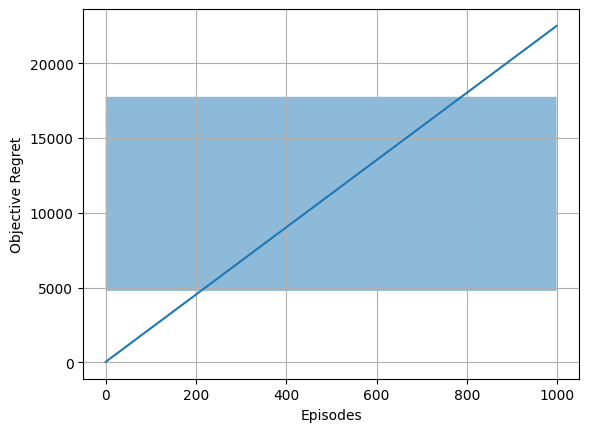

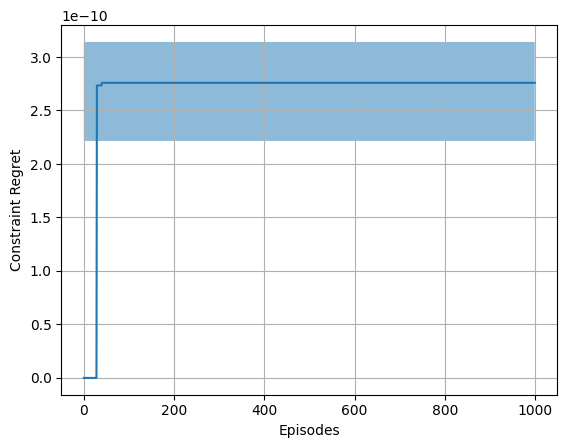

In [42]:
ObjRegret_mean = np.mean(Object_Regret, axis = 0)
ConRegret_mean = np.mean(Cost_Regret, axis = 0)
ObjRegret_std = np.std(Object_Regret, axis = 0)
ConRegret_std = np.std(Cost_Regret, axis = 0)


plt.figure()
plt.plot(range(NUMBER_EPISODES), Object_Regret)
plt.fill_between(range(NUMBER_EPISODES), ObjRegret_mean - ObjRegret_std, ObjRegret_mean + ObjRegret_std, alpha = 0.5)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Objective Regret')

plt.show()

plt.figure()
plt.plot(range(NUMBER_EPISODES), Cost_Regret)
plt.fill_between(range(NUMBER_EPISODES), ConRegret_mean - ConRegret_std, ConRegret_mean + ConRegret_std, alpha = 0.5)
plt.grid()
plt.xlabel('Episodes')
plt.ylabel('Constraint Regret')
# plt.title(title)
plt.show()

In [30]:
Object_Regret.shape

(1000,)